# Preface
This project is to explore the use of the Keras library will be used for image pre-processing and model creation. Mainly, the Keras ImageDataGenerator will be used for image augmentation as well as train, validation split. 

A stratified split approach will be used to split the images into train, validation and test sets. 10% of images from each label will first be split for the test set by calling a function, while the remaining images will be split between the training and validation sets in the ratio of 80% and 20% respectively via Keras ImageDataGenerator.

A pre-trained model, NASNetMobile, will be used to take advantage of the pre-trained weights in ImageNet. NASNetMobile was selected for its relatively high accuracy while being lightweight, hence making it ideal for importing to mobile devices.

# Procedures
The following are performed:
- Handling of the dataset
- Creation and training of model
- Validation of accuracy

### Handling of the dataset: Subdirectory creation
To implement the Keras pre-processing library, the images will have to be classified in sub-folders according to their labels.

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io as sio

#Create DataFrame with imagenames
filename = [x for root, dirs, files in os.walk("jpg") for x in files]
df = pd.DataFrame(filename)
df.rename(columns = {df.columns[0] : "filename"}, inplace = True)

#Read the labels file
data = sio.loadmat("imagelabels.mat")
df["oldlabel"] = pd.DataFrame(np.hstack((data["labels"])))

#Rename the labels to string objects to prevent int dtype errors
df["flower"] = "flower"
df["label"] = df["flower"] + df["oldlabel"].map(str)
df.drop(columns = ["flower", "oldlabel"], inplace = True)

#Display labels with their image count
df.label.value_counts()

flower51    258
flower77    251
flower46    196
flower73    194
flower89    184
           ... 
flower3      40
flower7      40
flower1      40
flower34     40
flower27     40
Name: label, Length: 102, dtype: int64

##### Note:
- Number of labels = 102
- Different labels have different number of images. Number of images range from 40 to 258

For this simple classification exercise, only labels with 40 or less images are used.

Due to the small dataset for each label, image augmentation is used to increase the dataset variation to prevent overfitting.

In [2]:
#Compile images of species >= 150 images
df_new = df[df["label"].map(df.label.value_counts() <= 40)]
df_new.label.value_counts()

flower27    40
flower34    40
flower21    40
flower3     40
flower7     40
flower45    40
flower1     40
Name: label, dtype: int64

In [3]:
#Function to create sub-folders for each label within the same directory
#Function heavily modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def create_folders(parent_dir, train_folder_name, test_folder_name, df, categories):
    
    #Create train and test folders in the same directory
    folders = [train_folder_name, test_folder_name]
        
    for folder in folders:
        if not os.path.isdir(folder):
            os.mkdir(folder)
            print(f"Folder {folder}, created!")
        else:
            print(f"Folder {folder}, exists!")
          
    #Create labels in the train and test folders
    for folder in folders:
        for i in categories:
            subfolder = str(i)
            path = os.path.join(f"{parent_dir}/" + folder, subfolder)
            if not os.path.isdir(path):
                os.mkdir(path)
            else:
                print(f"Folder {i}, exists in {folder}!")
    
    print(f"Folders and subfolders created for {train_folder_name} and {test_folder_name}!")

In [4]:
#Create the subfolders
parent_dir = r"C:\Users\Yong Jin\Desktop\Test"
train_folder_name = "train"
test_folder_name = "test"
categories = np.unique(df_new.label.values)

create_folders(parent_dir, train_folder_name, test_folder_name, df_new, categories) #Input df here

Folder train, created!
Folder test, created!
Folders and subfolders created for train and test!


In [5]:
#Function to move images to train subfolders
#Function modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def move_files(path, train_folder_name, df, map_dict):
    failed = 0
    
    for root, dirs, files in os.walk(path, topdown = True):
        for name in files:
            oldfile = os.path.join(root, name)
            newfile = os.path.join(f"{train_folder_name}/"+ map_dict[name], name)
                                   
            if not os.path.isdir(newfile):
                try:
                    os.rename(oldfile, newfile)
                    
                except:
                    failed += 1
    
    print("Completed transfer of images to train subfolders.")
    print(f"Failed to move {failed} images!")

In [6]:
#Call the functions to move images to train subfolders
#Note that images not in the selected labels will not be moved

path = "jpg" #Directory
map_dict = dict(df.values.tolist()) #Create dictionary of filename: labels for mapping

move_files(path, train_folder_name, df_new, map_dict) #Input df here

#Check number of images not in the selected labels to verify
df_nan = df[df["label"].map(df.label.value_counts() > 40)]
print(f'{sum(df_nan.label.value_counts())} images are not in the selected criteria.')

Completed transfer of images to train subfolders.
Failed to move 7909 images!
7909 images are not in the selected criteria.


In [7]:
#Function to move images to test subfolders
#Function modified from https://www.kaggle.com/ericbenhamou/sub-directories-for-keras-flow-from-directory
def move_test_images(train_folder_name, test_folder_name, df, test_ratio):
       
    for root, dirs, files in os.walk(train_folder_name, topdown = True):
        failed = 0
        train_num = len(files)
        
        if train_num == 0:
            continue
        
        test_num = 0
                 
        for name in files:
            oldfile = os.path.join(root, name)
            newfile = os.path.join(f"{test_folder_name}/" +
                                   root[len(train_folder_name) + 1:], 
                                   name)
            
            test_num += 1
                    
            if test_ratio < test_num / train_num: 
                continue #If test ratio met, move to the next subfolder
            
            if not os.path.isdir(newfile):
                try:
                    os.rename(oldfile, newfile)
                    
                except:
                    failed += 1
        
        if failed > 0:
            print(f"Failed to move {failed} files in {root}")
    
    print("Completed transfer of images to test subfolders.")

In [8]:
#Call the functions to split images to test subfolders
test_ratio = 0.1

move_test_images(train_folder_name, test_folder_name, df, test_ratio)

Completed transfer of images to test subfolders.


In [9]:
#Check that image mapping is correct
#Function code extracted from https://stackoverflow.com/questions/9727673/list-directory-tree-structure-in-python
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{subindent}{f}")

#Check that the list of images for Yellow_Bittern and Brahmini_Kite is correct
checklist = ["flower1"]

list_files(f"train/{checklist}")
list_files(f"test/{checklist}")

flower1/
    image_06738.jpg
    image_06739.jpg
    image_06740.jpg
    image_06741.jpg
    image_06742.jpg
    image_06743.jpg
    image_06744.jpg
    image_06745.jpg
    image_06746.jpg
    image_06747.jpg
    image_06748.jpg
    image_06749.jpg
    image_06750.jpg
    image_06751.jpg
    image_06752.jpg
    image_06753.jpg
    image_06754.jpg
    image_06755.jpg
    image_06756.jpg
    image_06757.jpg
    image_06758.jpg
    image_06759.jpg
    image_06760.jpg
    image_06761.jpg
    image_06762.jpg
    image_06763.jpg
    image_06764.jpg
    image_06765.jpg
    image_06766.jpg
    image_06767.jpg
    image_06768.jpg
    image_06769.jpg
    image_06770.jpg
    image_06771.jpg
    image_06772.jpg
    image_06773.jpg
flower1/
    image_06734.jpg
    image_06735.jpg
    image_06736.jpg
    image_06737.jpg


In [10]:
#Check the filename against the DataFrame mapping
df.query(f"label in {checklist}")

,filename,label
6733,image_06734.jpg,flower1
6734,image_06735.jpg,flower1
6735,image_06736.jpg,flower1
6736,image_06737.jpg,flower1
6737,image_06738.jpg,flower1
6738,image_06739.jpg,flower1
6739,image_06740.jpg,flower1
6740,image_06741.jpg,flower1
6741,image_06742.jpg,flower1
6742,image_06743.jpg,flower1


##### Note
The image names of the "flower1" label in the subfolders matches the label mapping in the DataFrame. Image transfer was sucessful.

### Handling of the dataset: Preprocessing and image augmentation
* As the model used is NASNetMobile, the respective preprocessing method will be used.
* Keras library is also utilised for the image augmentation during training.

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input

#Image augmentation parameters for training set
train_params = ImageDataGenerator(
                   rotation_range = 20, 
                   brightness_range = (0.5, 1.5), 
                   shear_range = 30, 
                   zoom_range = (0.8, 1.2), 
                   fill_mode = "nearest", 
                   horizontal_flip = True,
                   validation_split = 0.2,
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Creating the image augmentation
#Change directory as necessary
direc = "train" 

labels = np.unique(df_new.label.values).tolist()

#Training set
train_gen = train_params.flow_from_directory(
                    directory = direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2020,
                    subset = "training")

Found 203 images belonging to 7 classes.


In [12]:
#Image augmentation parameters for validation set (no augmentation of data)
valid_params = ImageDataGenerator(
                   validation_split = 0.2,
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Validation set
valid_gen = valid_params.flow_from_directory(
                    directory = direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = True,
                    seed = 2020,
                    subset = "validation")

Found 49 images belonging to 7 classes.


In [13]:
#Verify that all labels have at least 1 validation image
for i in range(len(labels)):
    if valid_gen.classes.tolist().count(i) < 1:
        print(f"Missing validation image from {list(valid_gen.class_indices.keys())[i]}")

In [14]:
#Image augmentation parameters for test set (Implementing Test Time Augmentation)
test_params = train_params = ImageDataGenerator(
                   preprocessing_function = preprocess_input) #Using NASNetMobile's preprocessing method

#Change directory as necessary
test_direc = "test"

#Validation set
test_gen = test_params.flow_from_directory(
                    directory = test_direc,
                    target_size = (224, 224), #Using the default image size of NASNetMobile for optimal results
                    color_mode = "rgb",
                    classes = labels,
                    class_mode = "categorical",
                    batch_size = 32,
                    shuffle = False,
                    seed = 2020)

Found 28 images belonging to 7 classes.


In [15]:
#Verify that all labels have at least 1 test image
for i in range(len(labels)):
    if test_gen.classes.tolist().count(i) < 1:
        print(f"Missing validation image from {list(test_gen.class_indices.keys())[i]}")

##### Note:
* All labels have at least 1 image for validation and testing.

### Creation and training of model
- Using NASNetMobile as base model
- Include a pooling layer and fully connected layer

In [16]:
#Setting up the NASNetMobile base model
inputs = (224, 224, 3)
base_model = NASNetMobile(include_top = False, weights = "imagenet", input_shape = inputs, pooling = "average")

for layer in base_model.layers[:]:
    layer.trainable = False

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(7, activation = "softmax"))

model.compile(optimizer = Adam(), 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

#Early stopping monitor if validation loss doesn't improve after 3 epochs to prevent overfitting 
#Save out the best model with the highest valuation accuracy
def scheduler(epoch):
    if epoch < 3:
        return 0.01
    if epoch < 8:
        return 0.001
    else:
        return 0.0001

callback = [EarlyStopping(monitor = "val_loss", patience = 3, mode = "min"),
            ModelCheckpoint(filepath = "best_model.hdf5", monitor = "val_loss", save_best_only = True),
            LearningRateScheduler(scheduler)]

#Fit the model
flower_model = model.fit(train_gen, 
                      epochs = 30,
                      shuffle = True,
                      validation_data = valid_gen,
                      callbacks = callback,
                      verbose = 1)

Epoch 1/30
7/7 [==============================] - 12s 2s/step - loss: 1.5347 - accuracy: 0.4286 - val_loss: 0.8894 - val_accuracy: 0.6939 - lr: 0.0100
Epoch 2/30
7/7 [==============================] - 11s 2s/step - loss: 0.6140 - accuracy: 0.7685 - val_loss: 0.3469 - val_accuracy: 0.8776 - lr: 0.0100
Epoch 3/30
7/7 [==============================] - 10s 1s/step - loss: 0.3462 - accuracy: 0.8818 - val_loss: 0.4932 - val_accuracy: 0.7551 - lr: 0.0100
Epoch 4/30
7/7 [==============================] - 9s 1s/step - loss: 0.2953 - accuracy: 0.8916 - val_loss: 0.3882 - val_accuracy: 0.8163 - lr: 0.0010
Epoch 5/30
7/7 [==============================] - 11s 2s/step - loss: 0.1974 - accuracy: 0.9507 - val_loss: 0.2656 - val_accuracy: 0.9184 - lr: 0.0010
Epoch 6/30
7/7 [==============================] - 10s 1s/step - loss: 0.1768 - accuracy: 0.9606 - val_loss: 0.2220 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 7/30
7/7 [==============================] - 10s 1s/step - loss: 0.2140 - accuracy: 0.9409

In [19]:
#Save the history of the best model
data = flower_model.history

with open("model_history.pickle", 'wb+') as out_file:
    pickle.dump(data, out_file)

##### Note
After fine tuning of the hyperparamters, the best model was saved out by the ModelCheckpoint callback and renamed as "flower_model_best.hdf5" to prevent over-writing. The history of the model was saved and renamed as "flower_model_history.pickle" to prevent over-writing.

In [21]:
#Loading the saved best model
from tensorflow.keras.models import load_model

saved_model = load_model("flower_model_best.hdf5")

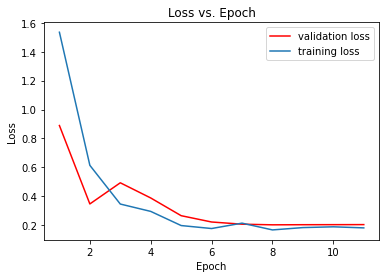

In [22]:
#Loading the saved instanced history of the saved model
with open("flower_model_history.pickle", "rb") as in_file:
    saved_model_history = pickle.load(in_file)

#Define the function of the loss graphs of the saved model
def plot_loss(model):
    train_acc = model["loss"]
    test_acc = model["val_loss"]
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = "red", label = "validation loss")
    plt.plot(x, train_acc, label = 'training loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epoch")
    plt.legend()
    
#Plot the loss graphs
plot_loss(saved_model_history)

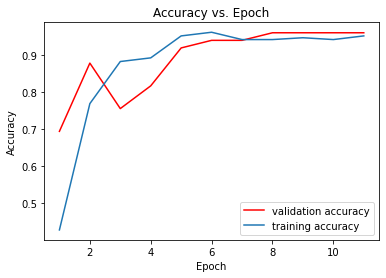

In [23]:
#Loading the saved instanced history of the saved model
with open("flower_model_history.pickle", "rb") as in_file:
    saved_model_history = pickle.load(in_file)

#Define the function of the loss graphs of the saved model
def plot_accuracy(model):
    train_acc = model["accuracy"]
    test_acc = model["val_accuracy"]
    x = list(range(1, len(test_acc) + 1))
    plt.plot(x, test_acc, color = "red", label = "validation accuracy")
    plt.plot(x, train_acc, label = 'training accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.legend()
    
#Plot the loss graphs
plot_accuracy(saved_model_history)

### Validation of accuracy
The trained model will be tested using the test set and evaluated using the performance metric Recall. Recall is used since the objective is to determine out of all the images of a particular label, how many were correctly identified as that label. 

In [24]:
#Evaluate the test images using the saved model
pred = saved_model.predict(test_gen)

In [25]:
from sklearn.metrics import classification_report, accuracy_score

#Convert the labels from array matrix to list of predicted and actual labels
class_names = list(test_gen.class_indices)

y_pred = [class_names[i] for i in list(np.argmax(pred, axis = -1))]
y_true = [class_names[i] for i in test_gen.classes.tolist()]

In [26]:
#Print the classification report
print(classification_report(y_true, y_pred, zero_division = 0))

              precision    recall  f1-score   support

     flower1       1.00      1.00      1.00         4
    flower21       1.00      1.00      1.00         4
    flower27       1.00      1.00      1.00         4
     flower3       1.00      1.00      1.00         4
    flower34       1.00      1.00      1.00         4
    flower45       1.00      1.00      1.00         4
     flower7       1.00      1.00      1.00         4

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



##### Evaluation:

* The support is indicative of how large the testing set is for the particular image.

* Overall Recall score was perfect at 1.00. This is due to the small number of labels used (7 out of 102), as well as great images with proper labelling (i.e. very little noise) in the training data, thanks to the great effort of the dataset owners. However in reality, such a score would be highly improbable.
* However, this project is mainly to showcase the use of the Keras library for image classification. Objective is met.